# FAISS on IMDB Dataset (Resnet18, 512d)

iMDB dataset contains around 460,000 rows. 

In [3]:
import numpy as np
import time
import matplotlib.pyplot as plt
from PIL import Image
import faiss 

from os import listdir
from os.path import isfile, join, splitext

In [4]:
embeddings_folder = 'data/500k_data'
image_folder = 'data/500k_data/imdb_images'
indexes_folder = 'indexes'

In [7]:
file_rn18 = 'rn18_embeds.txt'

start = time.time()
vectors_only = np.loadtxt(join(embeddings_folder, file_rn18), delimiter=",") # DO NOT USE GENFROMTXT, eats up too much RAM
# vectors_only = dd.read_csv(join(embeddings_folder, file_rn18), sep = ',')
print('Time taken : ', time.time() - start)

Time taken :  143.46206068992615


In [5]:
vectors_only.shape

(460723, 512)

In [17]:
filenames = 'filenames.txt'
%time arr_filenames = np.genfromtxt(join(embeddings_folder, filenames), delimiter="\n", dtype=str)

arr_filenames.shape

CPU times: user 2.07 s, sys: 942 ms, total: 3.01 s
Wall time: 4.42 s


(460723,)

In [6]:
%time xb = vectors_only.astype('float32')
xq = xb[1000:1001]  # set query vector. Take a random one from the dataset

print('xb.shape : ',xb.shape)
print('xq.shape: ', xq.shape)

CPU times: user 271 ms, sys: 233 ms, total: 504 ms
Wall time: 502 ms
xb.shape :  (460723, 512)
xq.shape:  (1, 512)


## Using Brute Force KNN Search

In [31]:
d = 512 # Number of dimensions

index = faiss.IndexFlatL2(d)
# index = faiss.IndexHNSWFlat(d, 25) # https://github.com/nmslib/nmslib/blob/master/python_bindings/parameters.md
# index.hnsw.efConstruction = 40 # Increasing this will increase recall but also indexing time
print('index.is_trained : ', index.is_trained)

%time index.add(xb)                  # add vectors to the index
print('index.ntotal : ', index.ntotal)

index.is_trained :  True
CPU times: user 168 ms, sys: 240 ms, total: 409 ms
Wall time: 405 ms
index.ntotal :  460723


In [9]:
faiss.write_index(index, join(indexes_folder, 'imdb_rn18_hnsw.index'))

In [35]:
k = 460723                       # we want to see 10 nearest neighbors
%time D, I = index.search(xq, k)     # actual search
print('I[:5] : ', I[:k])                   # neighbors of the 5 first queries
print('D[:5] : ', D[:k])

CPU times: user 770 ms, sys: 24.2 ms, total: 794 ms
Wall time: 261 ms
I[:5] :  [[  1000  18052 133336 ... 132106 372091 284940]]
D[:5] :  [[   0.        111.905045  126.79522  ... 1294.2328   1304.2859
  1304.2859  ]]


In [14]:
def get_map_image_filename(idx):
    image_filename = arr_filenames[idx,]
    print(image_filename)
    image_filename = image_filename + '.jpg'
    return image_filename

In [15]:
def draw_vector_map_image(I):
    plt.figure(figsize=(len(I[0])*4,4))
    for index, (array_index) in enumerate(zip(I[0])):
        fname = get_map_image_filename(array_index[0])
        im = Image.open(join(image_folder, fname))
        plt.subplot(1, len(I[0]), index+ 1)
        plt.imshow(im)
        titlestr = 'i:' + str(array_index[0]) + '  filename:', fname
        plt.title(titlestr, fontsize = 10)

nm0000060_rm3386546432_1916-4-5_1962
nm0000154_rm219188736_1956-1-3_1990
nm0001942_rm645323776_1957-2-22_1983
nm0609845_rm2936908544_1973-2-25_2011
nm0000323_rm2755185664_1933-3-14_1969
nm0089984_rm2755185664_1942-10-24_1969
nm0511458_rm653898240_1931-12-18_1963
nm0862026_rm653898240_1926-1-27_1963
nm0005128_rm4128889856_1968-3-29_1995
nm0000142_rm3611151360_1930-5-31_1982


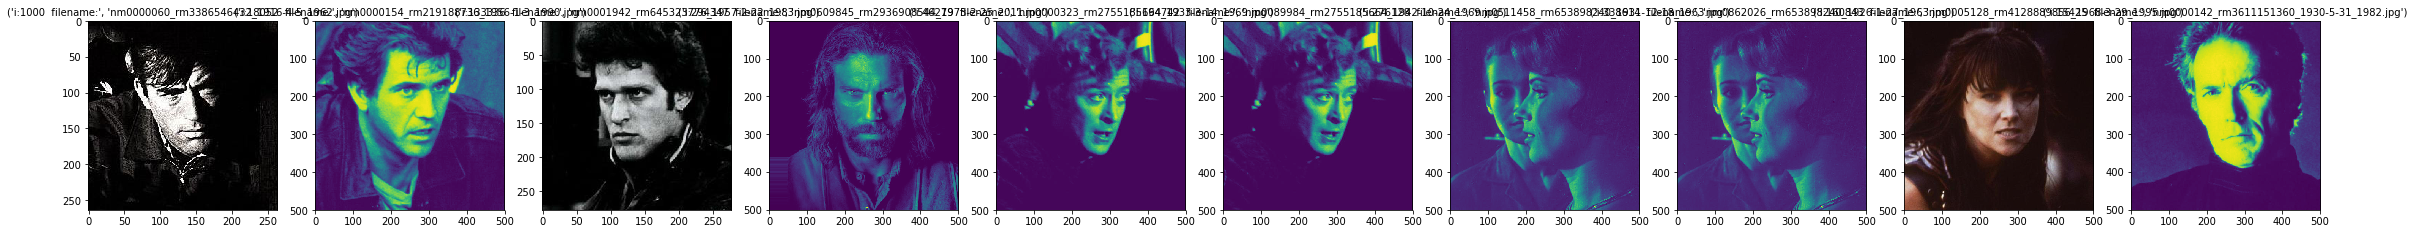

In [65]:
most_similar=I[:,:10]
least_similar=I[:,-10:] # 10 least similar
draw_vector_map_image(most_similar) # Where I is the indexes of the top images.

# FAISS on IMDB Dataset (Resnet50, 2048d)

In [3]:
file_rn50 = 'rn50_embeds.txt'

start = time.time()
vectors_only = np.loadtxt(join(embeddings_folder, file_rn50), delimiter=",") # DO NOT USE GENFROMTXT, eats up too much RAM
print('Time taken : ', time.time() - start)

Time taken :  512.5583958625793


In [4]:
vectors_only.shape

(460723, 2048)

In [6]:
np.save('data/500k_data/vector_binaries/imdb_rn18_512d.npy', vectors_only)

In [3]:
vectors_only = np.load('data/500k_data/vector_binaries/imdb_rn18_512d.npy')

In [4]:
%time xb = vectors_only.astype('float32')
xq = xb[1000:1001]  # set query vector. Take a random one from the dataset

print('xb.shape : ',xb.shape)
print('xq.shape: ', xq.shape)

CPU times: user 1.1 s, sys: 909 ms, total: 2.01 s
Wall time: 2.01 s
xb.shape :  (460723, 2048)
xq.shape:  (1, 2048)


## Use Brute Force KNN search

In [5]:
d = 2048 # Number of dimensions
nlist = 100

index = faiss.IndexFlatL2(d)
print('index.is_trained : ', index.is_trained)

%time index.train(xb)
%time index.add(xb)                  # add vectors to the index
print('index.ntotal : ', index.ntotal)

index.is_trained :  True
CPU times: user 13 µs, sys: 22 µs, total: 35 µs
Wall time: 39.1 µs
CPU times: user 712 ms, sys: 908 ms, total: 1.62 s
Wall time: 1.62 s
index.ntotal :  460723


In [6]:
faiss.write_index(index, join(indexes_folder, 'imdb_rn50_flatL2.index'))

In [7]:
k = 460723                       # we want to see 10 nearest neighbors
%time D, I = index.search(xq, k)     # actual search
print('I[:5] : ', I[:k])                   # neighbors of the 5 first queries
print('D[:5] : ', D[:k])

CPU times: user 620 ms, sys: 0 ns, total: 620 ms
Wall time: 588 ms
I[:5] :  [[  1000  18052 436960 ... 111288  47622  30290]]
D[:5] :  [[   0.         95.466446   96.63106  ... 1376.8591   1399.4581
  1399.4581  ]]


nm0000060_rm3386546432_1916-4-5_1962
nm0000154_rm219188736_1956-1-3_1990
nm2403277_rm433555456_1989-11-22_2009
nm0893941_rm433555456_1970-10-2_2009
nm0000213_rm941788672_1971-10-29_1990
nm0005342_rm352441600_1969-1-6_2010
nm0000374_rm3624570368_1950-3-18_1990
nm0228678_rm3624570368_1955-7-2_1990
nm0000154_rm2671758336_1956-1-3_1987
nm0000418_rm2671758336_1946-7-22_1987


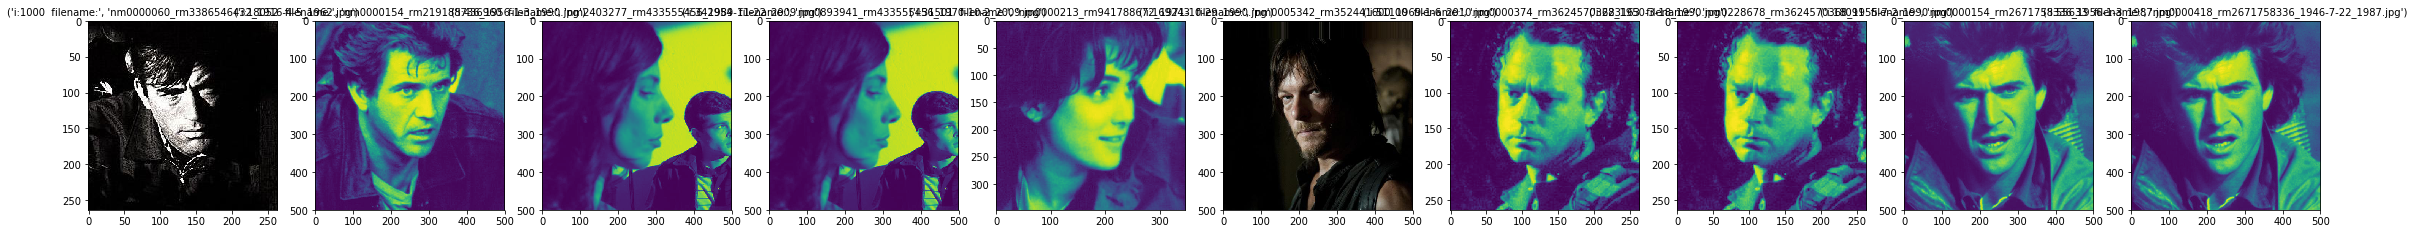

In [14]:
most_similar=I[:,:10]
least_similar=I[:,-10:] # 10 least similar
draw_vector_map_image(most_similar) # Where I is the indexes of the top images.

# FAISS on iMDB dataset (Alexnet, 4096d)

In [5]:
file_alex = 'alex_embeds.txt'

start = time.time()
vectors_only = np.loadtxt(join(embeddings_folder, file_alex), delimiter=",") # DO NOT USE GENFROMTXT, eats up too much RAM
print('Time taken : ', time.time() - start)

Time taken :  991.7354955673218


In [6]:
vectors_only.shape

(460723, 4096)

In [7]:
np.save('data/500k_data/vector_binaries/imdb_alex_4096d.npy', vectors_only)

In [8]:
%time xb = vectors_only.astype('float32')
xq = xb[1000:1001]  # set query vector. Take a random one from the dataset

print('xb.shape : ',xb.shape)
print('xq.shape: ', xq.shape)

CPU times: user 2.61 s, sys: 3.08 s, total: 5.69 s
Wall time: 5.69 s
xb.shape :  (460723, 4096)
xq.shape:  (1, 4096)


## Use Brute Force KNN search

In [9]:
d = 4096 # Number of dimensions

index = faiss.IndexFlatL2(d)
print('index.is_trained : ', index.is_trained)

%time index.train(xb)
%time index.add(xb)                  # add vectors to the index
print('index.ntotal : ', index.ntotal)

index.is_trained :  True
CPU times: user 70 µs, sys: 0 ns, total: 70 µs
Wall time: 8.25 ms
CPU times: user 2.29 s, sys: 3.75 s, total: 6.03 s
Wall time: 6.04 s
index.ntotal :  460723


In [10]:
faiss.write_index(index, join(indexes_folder, 'imdb_alex_flatL2.index'))

In [12]:
k = 460723                       # we want to see 10 nearest neighbors
%time D, I = index.search(xq, k)     # actual search
print('I[:5] : ', I[:k])                   # neighbors of the 5 first queries
print('D[:5] : ', D[:k])

CPU times: user 1.04 s, sys: 2.59 ms, total: 1.04 s
Wall time: 1.03 s
I[:5] :  [[  1000 195412 347757 ... 354024 358680 132106]]
D[:5] :  [[    0.      2651.06    2664.9502 ... 16748.164  18394.521  18394.521 ]]


nm0000060_rm3386546432_1916-4-5_1962
nm0094080_rm321312000_1967-5-9_2013
nm0915851_rm4236365312_1926-1-19_1976
nm0000163_rm4236365312_1937-8-8_1976
nm0915851_rm1015205376_1926-1-19_1976
nm0000163_rm1015205376_1937-8-8_1976
nm0000059_rm1015205376_1907-5-22_1976
nm0000059_rm4236365312_1907-5-22_1976
nm0089984_rm2755185664_1942-10-24_1969
nm0000323_rm2755185664_1933-3-14_1969


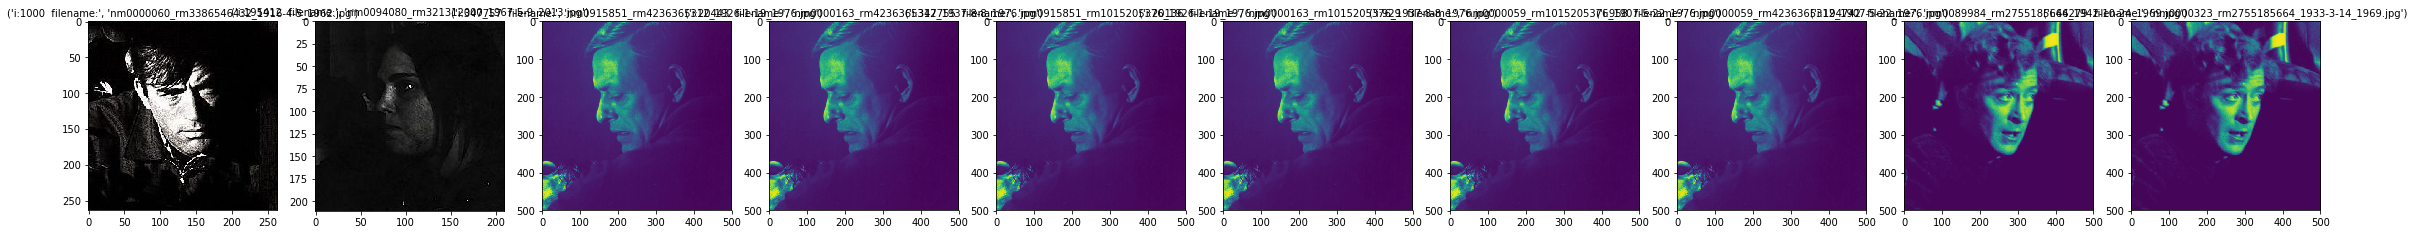

In [20]:
most_similar=I[:,:10]
least_similar=I[:,-10:] # 10 least similar
draw_vector_map_image(most_similar) # Where I is the indexes of the top images.